Let's start by loading the two datasets, indexing by date:

In [32]:
# Import data
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

import pandas as pd

counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [10]:
print(len(counts))
print(len(weather))
print(counts[:5])
print(weather[:5])

61296
1340
                     Fremont Bridge East Sidewalk  \
Date                                                
2019-01-01 00:00:00                           0.0   
2019-01-01 01:00:00                           2.0   
2019-01-01 02:00:00                           1.0   
2019-01-01 03:00:00                           1.0   
2019-01-01 04:00:00                           2.0   

                     Fremont Bridge West Sidewalk  
Date                                               
2019-01-01 00:00:00                           9.0  
2019-01-01 01:00:00                          22.0  
2019-01-01 02:00:00                          11.0  
2019-01-01 03:00:00                           2.0  
2019-01-01 04:00:00                           1.0  
                      STATION                                STATION_NAME  \
DATE                                                                        
2012-01-01  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-01-02  GHCND:USW0

Next we will compute the total daily bicycle traffic, and put this in its own dataframe:

In [11]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns
print(daily[:5])

             Total
Date              
2012-10-03  3521.0
2012-10-04  3475.0
2012-10-05  3148.0
2012-10-06  2006.0
2012-10-07  2142.0


We saw previously that the patterns of use generally vary from day to day; let's account for this in our data by adding binary columns that indicate the day of the week:

In [12]:
# add an indicator about Mon - Sun
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
    
print(daily[:5])

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun
Date                                                 
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0


Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [13]:
# add an indicator about holiday
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
# replace missing data with 0
daily['holiday'].fillna(0, inplace=True)

print(daily[:5])

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday
Date                                                          
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0


We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

C:\Users\tyler\AppData\Local\Temp\ipykernel_17104\1278859868.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday  daylight_hrs
Date                                                                        
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0     11.277359
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0     11.219142
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0     11.161038
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0     11.103056
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0     11.045208


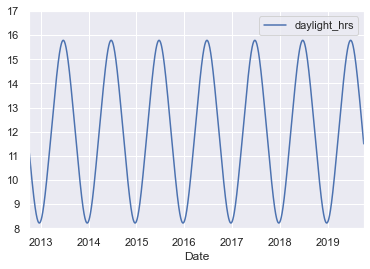

In [14]:
# This function seems crazy. The main goal is to calculate hours of daylight
# https://www.esrl.noaa.gov/gmd/grad/solcalc/sunrise.html here is an example...
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

print(daily[:5])

We can also add the average temperature and total precipitation to the data. In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [15]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
# how='left' means calling frame’s index 
# daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], how='left', lsuffix='_left', rsuffix='_right')

daily[:5]

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0


Finally, let's add a counter that increases from day 1, and measures how many years have passed. This will let us measure any observed annual increase or decrease in daily crossings:

In [16]:
# number of years passed
daily['annual'] = (daily.index - daily.index[0]).days / 365.

Now our data is in order, and we can take a look at it:

In [17]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


With this in place, we can choose the columns to use, and fit a linear regression model to our data. We will set fit_intercept = False, because the daily flags essentially operate as their own day-specific intercepts:

In [20]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

Finally, we can compare the total and predicted bicycle traffic visually:

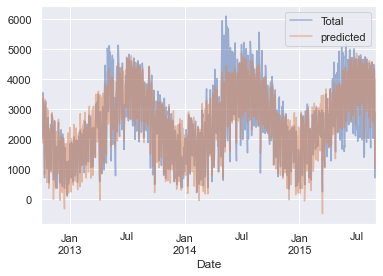

In [21]:
# a little bit different than our previous example
# this plot is from pandas
daily[['Total', 'predicted']].plot(alpha=0.5);

### Ridge Regression

In [22]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_rand

In [30]:
param_grid = {'alpha': sp_rand(0,100)}

model = Ridge()
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=1000, cv=10)
rsearch.fit(X, y)

print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha)

0.7710705485116875
4.729098751841998


In [28]:
modelR = Ridge(alpha=4.63)
modelR.fit(X, y)

Ridge(alpha=4.63)

In [33]:
cross_val_score(modelR, X, y, cv=10).mean().round(4)

0.7711

### Cross Validation Score for Ridge Regression is 0.7711

### Lasso Regression

In [38]:
from sklearn.linear_model import Lasso

param_grid = {'alpha': sp_rand(0,100)}

model = Lasso(max_iter=10000)
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=1000, cv=10)
rsearch.fit(X, y)

print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha)

0.7708917768285464
3.8050614958093254


In [36]:
modelL = Lasso(alpha = 3.79, max_iter = 10000)
modelL.fit(X,y)

Lasso(alpha=3.79, max_iter=10000)

In [37]:
cross_val_score(modelL, X, y, cv=10).mean().round(4)

0.7709

### Cross Validation Score for Lasso Regression is 0.7709